### Calculations and plotting for Figure 1

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
import importlib

In [3]:
from project_utils import parameters as param
from project_utils import utils as util
from project_utils import fig_utils as figu
importlib.reload(param)
importlib.reload(util)
importlib.reload(figu)

<module 'project_utils.fig_utils' from '/oak/stanford/groups/omramom/group_members/fvdav/projects/precip_clustering/project_utils/fig_utils.py'>

In [4]:
figu.set_plt_rc_params()

#### Read data on Billion Dollar Disaster Events

In [5]:
bdd_dat = pd.read_csv("../input_data/bdd-flood-events-US-1980-2020.csv", header = 1)

In [6]:
bdd_dat['date'] = pd.to_datetime(bdd_dat['Begin Date'], format = "%Y%m%d")

In [7]:
bdd_annual = bdd_dat.set_index('date').groupby('Region').resample('Y').sum().drop(
    columns = ['Begin Date', 'End Date']).reset_index()
bdd_annual['year'] = pd.DatetimeIndex(bdd_annual['date']).year
bdd_annual = bdd_annual.pivot(index = 'year', columns = 'Region', 
                              values = 'Total CPI-Adjusted Cost (Millions of Dollars)').fillna(0)

In [8]:
midwest_damage = int(np.round(bdd_annual.midwest.sum()/1000))
total_damage = int(np.round(bdd_annual.midwest.sum()/1000 + bdd_annual.other.sum()/1000))

In [9]:
pr_mean = xr.open_dataset("../processed_data/prism_mean_1981-01-01_2019-12-31.nc")

In [10]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [11]:
import geopandas as gpd
import regionmask

In [12]:
import cartopy.io.shapereader as sr

In [13]:
region_shp_file = "../processed_data/region.shp"

In [14]:
region = gpd.read_file(region_shp_file)
region_mask = regionmask.mask_geopandas(region, pr_mean)

In [15]:
mapcrs = ccrs.AlbersEqualArea(central_longitude=-95, central_latitude=35, standard_parallels=(30, 60))

In [16]:
precip_bounds = [-115, -80, 35, 50]

#### Calculate trend in number of extreme precipitation days per year

In [17]:
precip_dat = pd.read_csv("../processed_data/region_mean_precip.csv")
precip_dat['time'] = pd.to_datetime(precip_dat['time'])

In [18]:
pr_thr = precip_dat["prcp"].quantile(0.95)
precip_dat["extreme"] = 0
precip_dat.loc[precip_dat.prcp > pr_thr, 'extreme'] = 1

In [19]:
extreme_count = precip_dat.groupby(precip_dat.time.dt.year)['extreme'].sum().rename_axis('year')

In [20]:
early_ind = extreme_count.index <= param.early_stop
early_plot_ind = extreme_count.index <= param.early_stop + 1
late_ind = extreme_count.index > param.early_stop

In [21]:
x = extreme_count.index
y = extreme_count.values
ex_int, ex_slope, ex_pval = util.fit_ols(x, y)
ex_int_early, ex_slope_early, ex_pval_early = util.fit_ols(x[early_ind], y[early_ind])
ex_int_late, ex_slope_late, ex_pval_late = util.fit_ols(x[late_ind], y[late_ind])

#### read in GHCN station data and calculate trends

In [22]:
ghcn_dat = pd.read_csv("../processed_data/ghcn_midwest_data.csv",
                       dtype = {'ID': 'string', 'DATE': 'int64',
                        'DATA_VALUE': 'float64', 'LATITUDE': 'float64', 'LONGITUDE': 'float64'})

In [23]:
station_IDs = np.unique(ghcn_dat.ID)

In [24]:
ghcn_dat['date'] = pd.to_datetime(ghcn_dat['DATE'], format = "%Y%m%d").dt.date.astype('string')
ghcn_dat['year'] = pd.to_datetime(ghcn_dat['DATE'], format = "%Y%m%d").dt.year

In [25]:
p95_thr = ghcn_dat.DATA_VALUE.groupby(ghcn_dat.ID).quantile(0.95).reset_index().rename(
          columns = {"DATA_VALUE": "p95"})
ghcn_dat = ghcn_dat.join(p95_thr.set_index("ID"), on = "ID", how = "left")
ghcn_dat['extreme'] = np.where(ghcn_dat.DATA_VALUE >= ghcn_dat.p95, 1, 0)

In [26]:
p95_annual = ghcn_dat.groupby([ghcn_dat.ID, ghcn_dat.year])['extreme'].sum().reset_index()

p95_trend = []
p95_trend_late = []

for sta in station_IDs:
    df = p95_annual.loc[(p95_annual.ID == sta)]
    p95_trend.append(np.polyfit(df.year, df.extreme, deg = 1)[0])
    
    df = p95_annual.loc[(p95_annual.ID == sta) & (p95_annual.year >= 2000)]
    p95_trend_late.append(np.polyfit(df.year, df.extreme, deg = 1)[0])

In [27]:
ghcn_plot_df = pd.DataFrame({"ID": station_IDs, "p95_trend": p95_trend,
                          "p95_trend_late": p95_trend_late})
ghcn_plot_df = ghcn_plot_df.join(ghcn_dat[["ID", "LONGITUDE", "LATITUDE"]].drop_duplicates().set_index("ID"), 
                                 on = "ID", how = "left")

In [28]:
basin_file = "../input_data/Watershed_Boundary_Dataset/WBD_10_HU2_Shape/WBDHU2.shp"
basin_file2 = "../input_data/Watershed_Boundary_Dataset/WBD_07_HU2_Shape/WBDHU2.shp"

### Figure 1

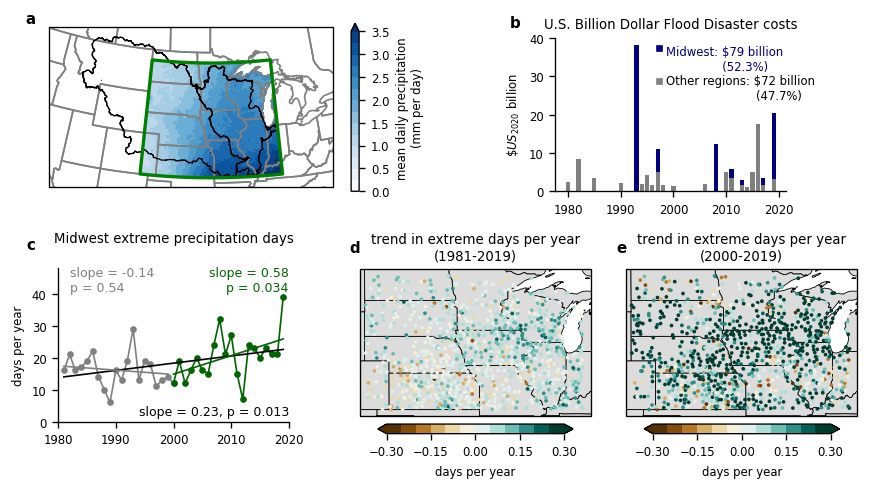

In [29]:
fig = plt.figure(figsize = (7.4, 4))

ax = fig.add_axes([0.05, 0.6, 0.4, 0.35], projection = mapcrs)
ax.set_extent(precip_bounds)

p = pr_mean['prcp'].where(region_mask == 0).plot(
    levels = np.arange(0, 3.75, 0.25), extend = 'max', cmap = 'Blues', 
    cbar_kwargs = dict(label = 'mean daily precipitation\n(mm per day)'),
    transform = ccrs.PlateCarree())

ax.add_feature(cfeature.STATES.with_scale('50m'), facecolor = 'none', edgecolor = "gray")
ax.add_geometries(sr.Reader(basin_file).geometries(), crs = ccrs.PlateCarree(), facecolor = 'none', 
                  edgecolor = 'black', linewidth = 0.7)
ax.add_geometries(sr.Reader(basin_file2).geometries(), crs = ccrs.PlateCarree(), facecolor = 'none', 
                  edgecolor = 'black', linewidth = 0.7)
ax.add_geometries(sr.Reader(region_shp_file).geometries(), 
                  crs = ccrs.PlateCarree(), facecolor = 'none', edgecolor = figu.region_col, linewidth = 2)
figu.add_panel_label(ax, 'a', x = -0.05, y = 1.1)

ax = fig.add_axes(np.array([0.62, 0.60, 0.26, 0.32]))
ax.bar(x = bdd_annual.index, 
        height = bdd_annual.other/1000, 
       color = figu.base_col)

ax.bar(x = bdd_annual.index, 
        height = bdd_annual.midwest/1000, 
        bottom = bdd_annual.other/1000, color = 'navy')

ax.text(0.48, 0.95, 'Midwest: \$' + str(midwest_damage) + ' billion\n               (' + 
         str(np.round(midwest_damage/total_damage*100, 1)) + '%)', 
        transform = ax.transAxes, size = 7, ha = 'left', va = 'top', color = 'navy')
ax.plot(0.45, 0.93, marker = 's', color = 'navy', markersize = 3, linestyle = 'none', transform = ax.transAxes)
ax.text(0.48, 0.76, 'Other regions: \$' + str(total_damage - midwest_damage) + ' billion\n                        (' + 
         str(100-np.round(midwest_damage/total_damage*100, 1)) + '%)', 
        transform = ax.transAxes, size = 7, ha = 'left', va = 'top', color = 'k')
ax.plot(0.45, 0.72, marker = 's', color = figu.base_col, markersize = 3, linestyle = 'none', transform = ax.transAxes)
ax.set(ylabel = '\$$US_{2020}$ billion', title = 'U.S. Billion Dollar Flood Disaster costs')
figu.format_plot(ax)
figu.add_panel_label(ax, 'b', x = -0.15)

ax = fig.add_axes(np.array([0.06,0.12,0.26,0.32]))
x = extreme_count.index
y = extreme_count.values
i = 2
ax.plot(x[early_plot_ind], y[early_plot_ind], 
        color = figu.base_col, marker = '.')
ax.plot(x[late_ind], y[late_ind], marker = '.', color = figu.midwest_col)
## plot trend lines
ax.plot(x, x*ex_slope + ex_int, color = 'k')
ax.plot(x[early_ind], x[early_ind]*ex_slope_early + ex_int_early, color = figu.base_col)
ax.plot(x[late_ind], x[late_ind]*ex_slope_late + ex_int_late, color = figu.midwest_col)
## plot text
ax.text(x = 1, y = 0.04, s = 'slope = ' + str(np.round(ex_slope, 2)) + 
        ', p = ' + str(np.round(ex_pval, 3)), 
       transform=ax.transAxes, size = 7.5, horizontalalignment='right')
ax.text(x = 0.05, y = 0.85, s = 'slope = ' + str(np.round(ex_slope_early, 2)) + 
        '\np = ' + str(np.round(ex_pval_early, 2)), 
       transform=ax.transAxes, size = 7.5, color = figu.base_col, horizontalalignment='left')
ax.text(x = 1, y = 0.85, s = 'slope = ' + str(np.round(ex_slope_late, 2)) + 
        '\np = ' + str(np.round(ex_pval_late, 3)), 
       transform=ax.transAxes, size = 7.5, color = figu.midwest_col, horizontalalignment='right')

ax.set(title = 'Midwest extreme precipitation days\n', ylim = (0,48), xlim = (1980, 2020), 
       ylabel = "days per year")
figu.format_plot(ax)
figu.add_panel_label(ax, 'c', y = 1.2)

ax = fig.add_axes([0.4,0.12,0.26,0.33], projection = ccrs.PlateCarree())
p = ax.scatter(ghcn_plot_df.LONGITUDE, ghcn_plot_df.LATITUDE, c=ghcn_plot_df.p95_trend, 
               cmap = figu.browngreen, vmin = -0.3, vmax = 0.3, s = 1.5,
               zorder = 10)
figu.format_ghcn_map(ax)
ax.set(title='trend in extreme days per year\n(1981-2019)')
figu.add_panel_label(ax, 'd', x = 0, y = 1.2)
cbaxes = fig.add_axes([0.42, 0.095, 0.22, 0.02]) 
cbar = fig.colorbar(p, cax = cbaxes, extend = "both", label = "days per year", 
                    orientation = "horizontal", 
                   ticks = np.arange(-0.3, 0.45, 0.15))
cbar.ax.tick_params(labelsize=7)

ax = fig.add_axes([0.7, 0.12, 0.26, 0.33], projection = ccrs.PlateCarree())
p = ax.scatter(ghcn_plot_df.LONGITUDE, ghcn_plot_df.LATITUDE, c=ghcn_plot_df.p95_trend_late, 
               cmap = figu.browngreen, vmin = -0.3, vmax = 0.3, s = 1.5,
               zorder = 10)
figu.format_ghcn_map(ax)
ax.set(title='trend in extreme days per year\n(2000-2019)')
cbaxes = fig.add_axes([0.72, 0.095, 0.22, 0.02])
cbar = fig.colorbar(p, cax = cbaxes, extend = "both", label = "days per year",
            orientation = "horizontal", 
                   ticks = np.arange(-0.3, 0.45, 0.15))
cbar.ax.tick_params(labelsize=7)
figu.add_panel_label(ax, 'e', x = 0, y = 1.2)

fig.savefig("../figures/figure_1.pdf")